### Importing your libraries and data

In [5]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [6]:
# Data set path

path = r"/Users/martin/anaconda_projects/24-03-2025 Advanced Analytics & Dashboard Design"

In [7]:
# Import time series data (quandl isn´t working)

df = pd.read_csv(os.path.join(path, '02 data' , 'Original Data' , 'Example_Time_Series_Data.csv'))

In [8]:
print(df.columns)

Index(['date', 'unemployment_rate'], dtype='object')


For this analysis, I used a simulated monthly dataset representing the unemployment rate between 2010 and 2024.  
While this data is not part of the original Airbnb dataset, it is conceptually relevant to the project,  
as economic indicators such as unemployment can influence tourism and short-term rental demand in cities like Amsterdam.

### 3. Time Series Formatting and Initial Visualization

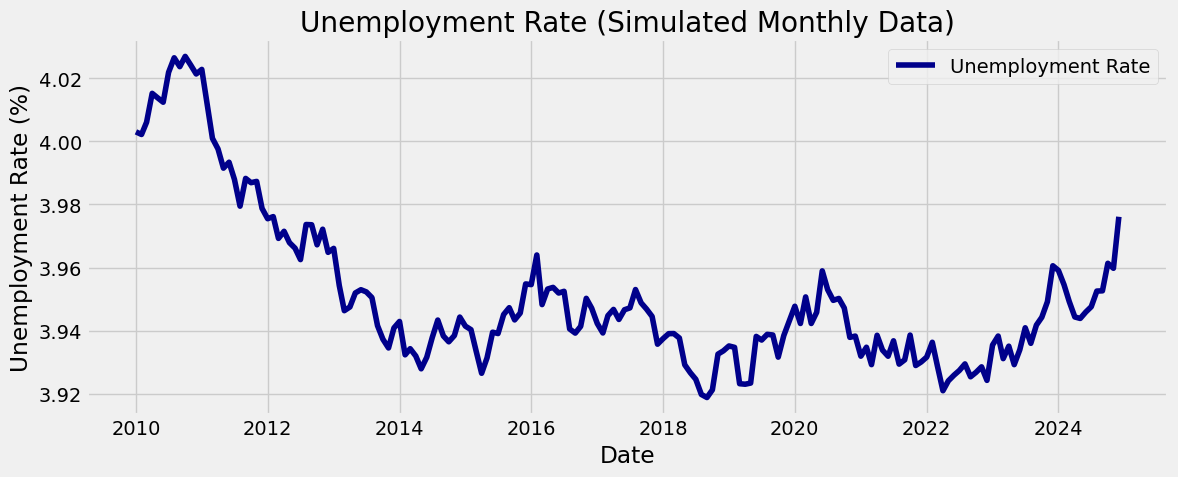

In [11]:
# Convert date column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df, label='Unemployment Rate', color='darkblue')
plt.title('Unemployment Rate (Simulated Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()

# Define the file path
save_path = "/Users/martin/anaconda_projects/24-03-2025 Advanced Analytics & Dashboard Design/04 Analysis/Visualizations/unemployment_rate_timeseries.jpg"

# Save the figure BEFORE showing it
plt.savefig(save_path, format="jpg", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


The line chart visualizes the unemployment rate from 2010 to 2024 using simulated monthly data.  
We can observe a general downward trend until around 2016, followed by a period of relative stability and a slight upward trend starting in 2023.

The series also shows signs of short-term fluctuation, suggesting possible seasonality and non-stationarity.  
This plot serves as the starting point for the deeper time series analysis and decomposition.

### 4. Decomposing the Time Series into Components

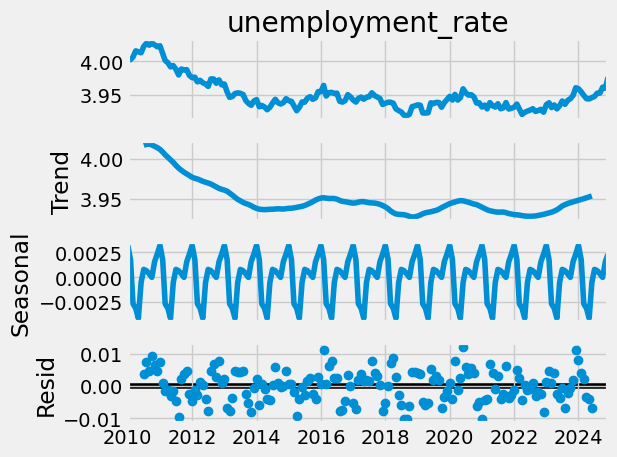

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition (recommended for linear trends)
decomposition = seasonal_decompose(df['unemployment_rate'], model='additive', period=12)

# Plot the components
decomposition.plot()
plt.tight_layout()
plt.show()

The time series was decomposed into its three main components:

- **Trend**: Shows a long-term pattern with a mild decrease until around 2016, then stabilizes and slightly increases towards the end.
- **Seasonality**: Clear repeating pattern throughout the years, which indicates a strong seasonal component in the data.
- **Residual (Noise)**: Contains small irregular fluctuations not explained by the trend or seasonal component.

The decomposition confirms that the series is **not stationary**, due to both the clear trend and the seasonal cycles.
This justifies the need for further transformation before forecasting.

### 5. Testing for Stationarity (Dickey-Fuller Test)

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['unemployment_rate'])

# Print results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.086694697113099
p-value: 0.2498982776264136
Critical Values:
   1%: -3.4674201432469816
   5%: -2.877826051844538
   10%: -2.575452082332012


The Augmented Dickey-Fuller test returned the following results:

- **ADF Statistic**: -2.0867  
- **p-value**: 0.2499  
- **Critical Value (5%)**: -2.8778  

Since the p-value is greater than 0.05 and the ADF statistic is higher than the 5% critical value,  
I fail to reject the null hypothesis. This confirms that the series is **non-stationary** and must be transformed before forecasting.

### 6. First Differencing to Achieve Stationarity

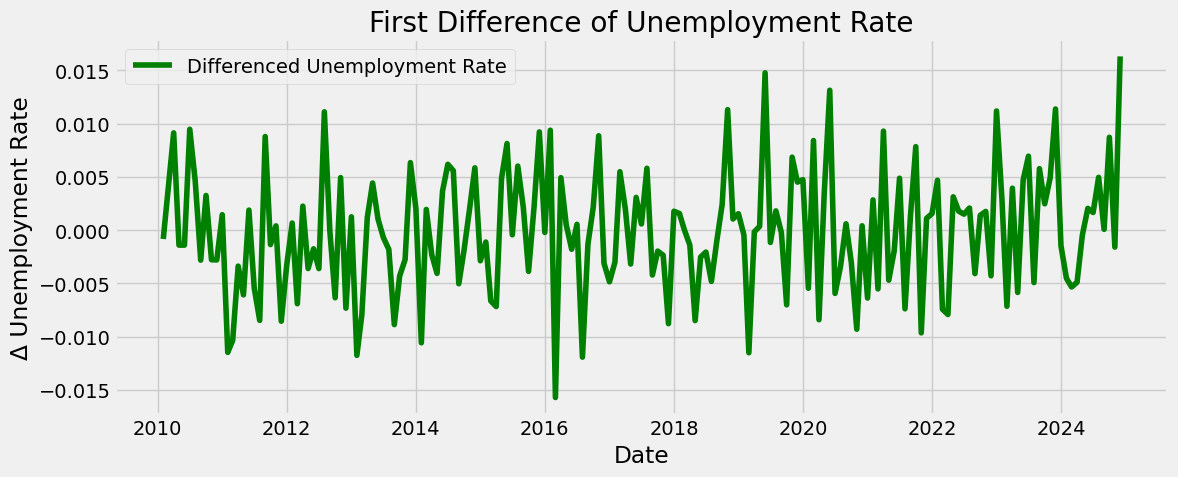

In [20]:
# Apply first-order differencing
df_diff = df.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(df_diff, label='Differenced Unemployment Rate', color='green')
plt.title('First Difference of Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Δ Unemployment Rate')
plt.legend()
plt.tight_layout()
plt.show()

After applying first-order differencing, the time series no longer shows a clear trend or seasonality.  
The values now fluctuate around a stable mean of zero, which is typical for a stationary series.

This transformation helps eliminate non-stationary components and prepares the data for forecasting models.  
The visible increase in short-term variation suggests the transformation was successful, though a statistical test will confirm this in the next step.

### 7. Testing Stationarity After Differencing

In [23]:
# Perform Dickey-Fuller test on differenced series
result_diff = adfuller(df_diff['unemployment_rate'])

# Output results
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic (Differenced): -13.927595220033892
p-value: 5.1590664047703916e-26
Critical Values:
   1%: -3.467631519151906
   5%: -2.8779183721695567
   10%: -2.575501353364474


The Augmented Dickey-Fuller test on the differenced series returned the following results:

- **ADF Statistic**: –13.93  
- **p-value**: 5.16e–26  
- **Critical Value (5%)**: –2.88  

Since the p-value is far below 0.05 and the ADF statistic is lower than all critical values,  
I can reject the null hypothesis and confirm that the differenced series is now **stationary**.

This means the data is now suitable for forecasting models.

### 8. Autocorrelation Check (ACF Plot)

<Figure size 1200x500 with 0 Axes>

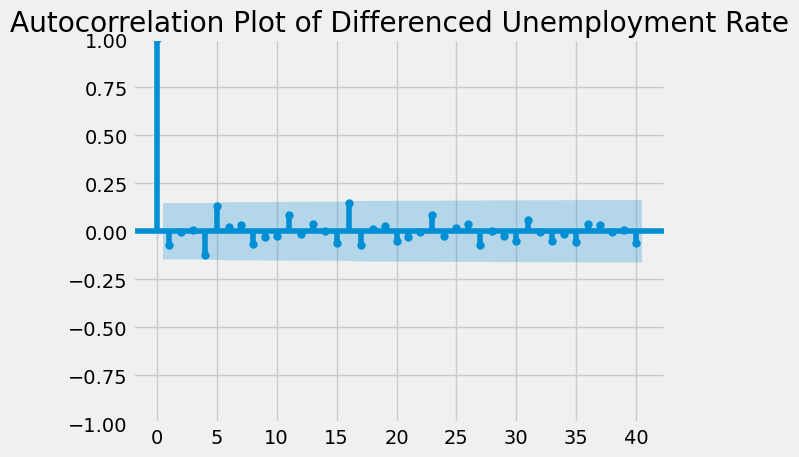

In [26]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelations of the differenced series
plt.figure(figsize=(12, 5))
plot_acf(df_diff['unemployment_rate'], lags=40)
plt.title('Autocorrelation Plot of Differenced Unemployment Rate')
plt.tight_layout()
plt.show()

The autocorrelation plot of the differenced series shows that most lags fall within the 95% confidence interval.  
Only a few minor spikes appear, which indicates that there is **no significant autocorrelation** left in the data.

This further supports the conclusion that the series is now **stationary and well-prepared for forecasting**.


### 9. Conclusion and Notebook Submission

In this notebook, I conducted an end-to-end time series analysis using simulated unemployment data.  
The goal was to prepare the data for forecasting by applying the following steps:

1. Imported and explored the data  
2. Visualized the time series  
3. Decomposed the series into trend, seasonality, and noise  
4. Tested for stationarity using the Dickey-Fuller test  
5. Applied differencing to make the series stationary  
6. Re-tested for stationarity  
7. Checked for autocorrelation

All steps confirmed that the transformed series is now stationary and suitable for forecasting.  
This concludes the analysis, and the notebook is ready for submission.


In [ ]:
# Export data to csv

df_cluster.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'listings_clustered.csv'), index=False)